# CNN for Histopathologic Cancer Detection ( Kaggle )

**Link to the competition [Page](https://www.kaggle.com/competitions/histopathologic-cancer-detection)**.

### Github Repository for the notebook

[https://github.com/jagrat89/HistoCNN]()

# Problem Statement

In the provided dataset, you are given numerous small pathology images that you must classify. Each file is identified by an image ID, and the corresponding labels are found in the **train_labels.csv** file, which serves as the ground truth for the images in the training folder. Your task is to predict the labels for the images located in the test folder.

A label is deemed positive if there is at least one pixel of tumor tissue within the central 32x32 pixel region of an image patch. The presence of tumor tissue in the peripheral area of the patch does not affect the label. This design choice allows for the utilization of fully-convolutional models that avoid zero-padding, ensuring uniform behavior when applied to an entire slide image.

While the original PCam dataset includes duplicate images as a result of probabilistic sampling, the version made available for this Kaggle competition has been modified to exclude any duplicates. Aside from this modification, the data and divisions remain consistent with the PCam benchmark standard.

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation, add
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import tensorflow as tf
from keras import models
from sklearn.model_selection import train_test_split
from keras.models import load_model
import math
from keras.utils import plot_model


# EDA and Visualisation

In [9]:
train_labels = pd.read_csv("train_labels.csv")

### Understanding the data

In [4]:
train_labels.columns

Index(['id', 'label'], dtype='object')

### Transforming the data, typecasting the label column to _string_ and appending ".tif" to the id's for future utiility 

In [10]:
train_labels['label'] = train_labels['label'].astype(str)
train_labels['id'] = train_labels['id'].astype(str) + '.tif'

### Length of the training data

In [6]:
training_data_len = train_labels.id.size
print(f"Length of training data is {training_data_len}")

Length of training data is 220025


### Read in one image to analyse its dimensions and properties

In [7]:
image_id = train_labels["id"][0]
image_path = f"train/{image_id}"

pathology_image = image.load_img(image_path)
print(f"Image dimensions {pathology_image.size}")

image_arr = image.img_to_array(pathology_image)

print(f"Shpae of the Image array {image_arr.shape} ") 

print(f"RGB Values at the (0, 0) position on the image {image_arr[0, 0]}")

Image dimensions (96, 96)
Shpae of the Image array (96, 96, 3) 
RGB Values at the (0, 0) position on the image [246. 246. 244.]


### Visualising the image of dimension (96, 96, 3)

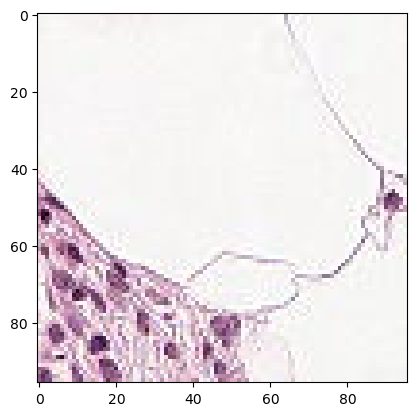

In [8]:
plt.imshow(pathology_image)
plt.show()

### How is the training data distributed in postitve and negative?

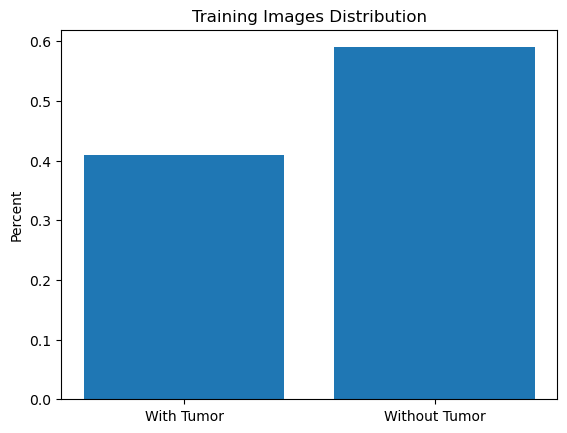

In [9]:
positive_rate = round(sum(train_labels["label"] == "1") / training_data_len,2)
values = [positive_rate, 1 - positive_rate]
labels = ['With Tumor', 'Without Tumor']
plt.bar(labels, values)
plt.ylabel('Percent')
plt.title('Training Images Distribution')
plt.show()

### As per the guidelines in the competition, the (32, 32) center portion of the image should be checked for a tumor issue. Let's look at five positive zoomed images with five negative zoomed in images to get a better idea.

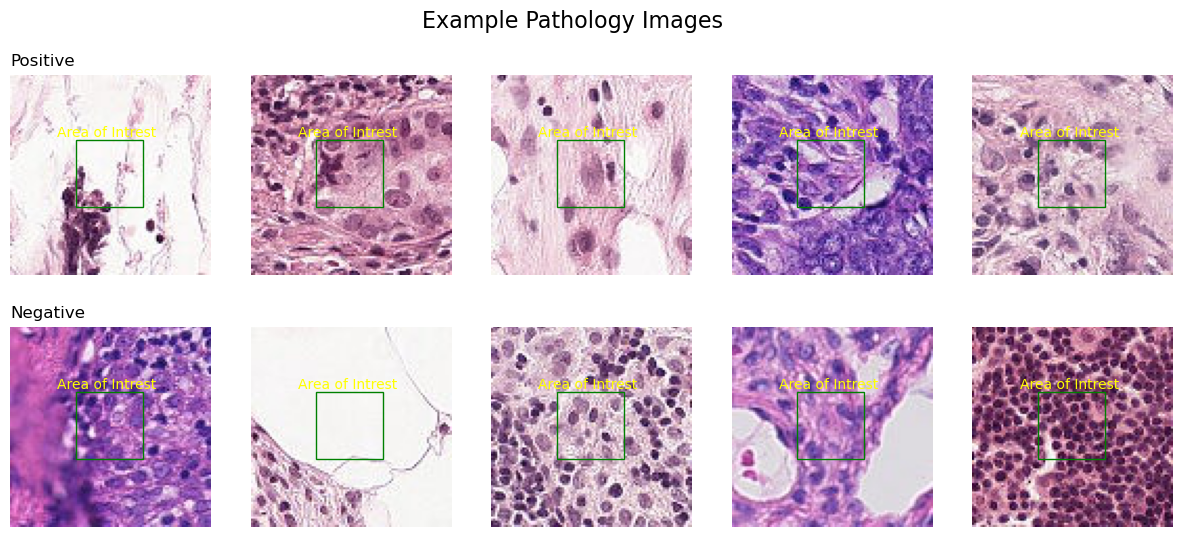

In [10]:
positive_image_ids = (train_labels.where(train_labels["label"] == "1").dropna()["id"][:6]).values
negative_image_ids = (train_labels.where(train_labels["label"] == "0").dropna()["id"][:6]).values


def img_lst(id_lst):
    img_lst = []
    for i in id_lst.flat:
        img = image.load_img(f"train/{i}")
        img_lst.append(img)
    return img_lst

image_arrays = img_lst(np.vstack((positive_image_ids, negative_image_ids)))



fig, axes = plt.subplots(2, 5, figsize=(15, 6))
row_titles = ["Positive", "Negative"]

plt.suptitle('Example Pathology Images', fontsize=16)

center_x, center_y = 47, 47
width, height = 32, 32
top_left_x = center_x - width / 2
top_left_y = center_y - height / 2

for i, ax in enumerate(axes.flat):
    ax.imshow(image_arrays[i]) 
    ax.axis('off')   
    
    rect = plt.Rectangle((top_left_x, top_left_y), width, height, edgecolor='green', facecolor='none') 
    ax.add_patch(rect)
    ax.text(top_left_x + 15, top_left_y - 7, 'Area of Intrest', color='yellow', ha='center', va='top')

    
for i, ax_row in enumerate(axes):
    ax_row[0].set_title(row_titles[i], loc='left')
plt.show()

### Helper Function for plotting

In [14]:
def plot_metrics(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history['accuracy'], label='Training Accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()

### Creating ImageDataGenerator for training and validation. 

In [11]:
datagen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
        dataframe=train_labels,
        directory='train',
        x_col='id',
        y_col='label',
        target_size=(96, 96), 
        #batch_size=250,
        class_mode='binary',
        subset='training',
        shuffling = True
    )


validation_generator = datagen.flow_from_dataframe(
        dataframe=train_labels,
        directory='train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        class_mode='binary',
        #batch_size=250,
        subset='validation',
        shuffling = True
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# VGG-16

VGG architecture was first introduced in [this paper](https://arxiv.org/pdf/1409.1556v6.pdf), VGG demonstrated that repeated small convolutions can provide the same receptive field as large convolutions but at the same time being much more efficient. Below is an example of a VGG architecture with 19 layers:

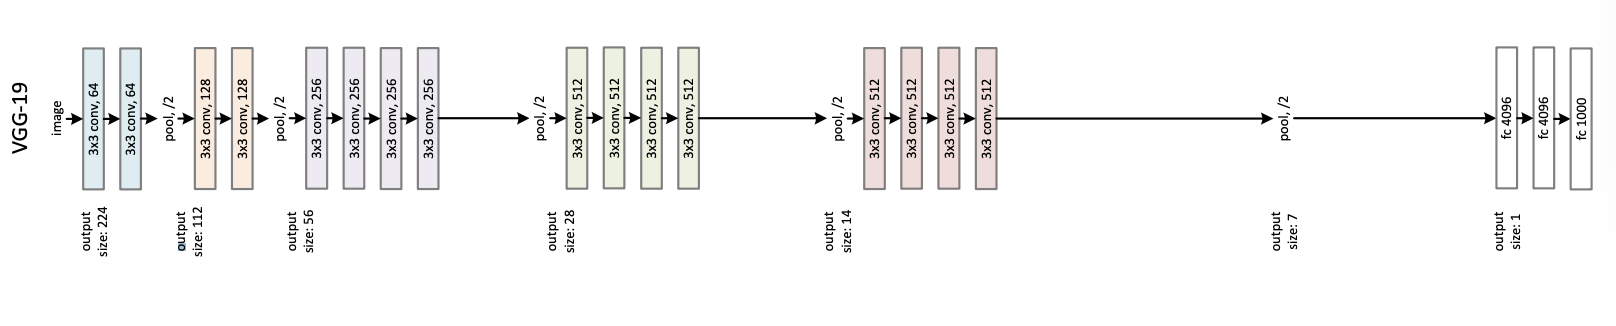'

[Image Source](https://arxiv.org/pdf/1512.03385v1.pdf)

### Implementation Reference from the paper

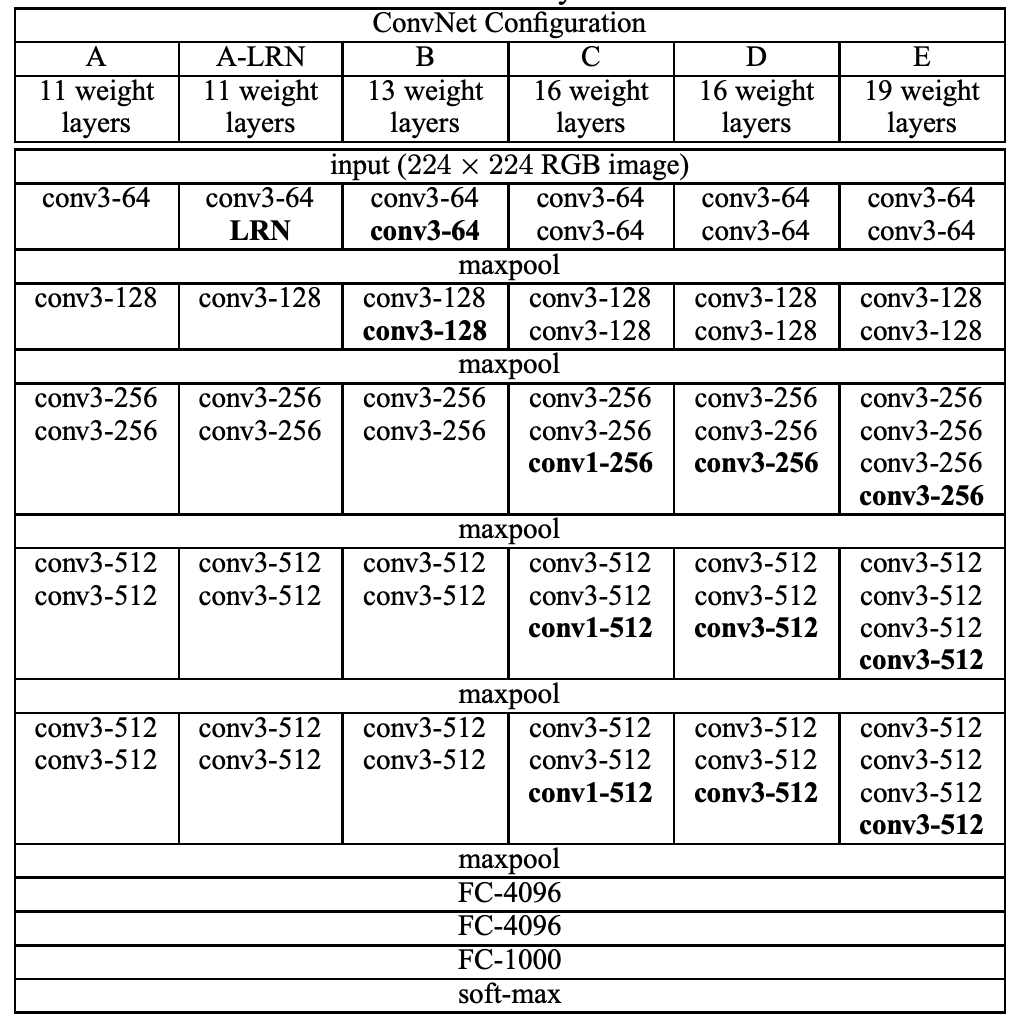



### Implementation 

I will be using the ConvNet configuration C with 16 layers. The configuration of the VGG-16 architecture will consists of repeating 3x3 convolution with stride 1 and max pool layer of 2x2 and stride 2, the ReLU function will be applied after each convolution. Towards the end there are two FC layer of 4096 neurons with ReLU activation, and at last a single sigmoid neuron for generating the binary classification.

In [11]:
vgg_model = Sequential()

# first phase of convolution all the convolution here have 64 channels
vgg_model.add(Conv2D(input_shape=(96,96,3),filters = 64, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

# second phase of convolution, the size of all the channels is 128
vgg_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

#channel size = 256
vgg_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 256, kernel_size = (1,1), padding = "same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

#channel size = 512
vgg_model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 512, kernel_size = (1,1), padding = "same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

#channel size = 512
vgg_model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation="relu"))
vgg_model.add(Conv2D(filters = 512, kernel_size = (1,1), padding = "same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

Once the Convolution parts are done now let's add the FC layers.

In [12]:
vgg_model.add(Flatten())
vgg_model.add(Dense(units=4096, activation = "relu"))
vgg_model.add(Dense(units=4096, activation = "relu"))
vgg_model.add(Dense(units=1, activation = "sigmoid"))

In [13]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                   

### Training the model

In [14]:
vgg_model.compile(optimizer=Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')

history = vgg_model.fit(
    train_generator,
    steps_per_epoch= 250,
    validation_data=validation_generator,
    validation_steps = 50,
    epochs=100,
    callbacks = [early_stopping]
)

Epoch 1/100
250/250 [==============================] - 256s 1s/step - loss: 0.5653 - accuracy: 0.7204 - val_loss: 0.4651 - val_accuracy: 0.7837
Epoch 2/100
250/250 [==============================] - 254s 1s/step - loss: 0.4902 - accuracy: 0.7716 - val_loss: 0.5057 - val_accuracy: 0.7606
Epoch 3/100
250/250 [==============================] - 253s 1s/step - loss: 0.4727 - accuracy: 0.7868 - val_loss: 0.4295 - val_accuracy: 0.7994
Epoch 4/100
250/250 [==============================] - 254s 1s/step - loss: 0.4550 - accuracy: 0.7922 - val_loss: 0.4143 - val_accuracy: 0.8156
Epoch 5/100
250/250 [==============================] - 254s 1s/step - loss: 0.4418 - accuracy: 0.7974 - val_loss: 0.4387 - val_accuracy: 0.7862
Epoch 6/100
250/250 [==============================] - 250s 999ms/step - loss: 0.4381 - accuracy: 0.8035 - val_loss: 0.4040 - val_accuracy: 0.8231
Epoch 7/100
250/250 [==============================] - 253s 1s/step - loss: 0.4290 - accuracy: 0.8065 - val_loss: 0.4516 - val_accura

### Visualising the training

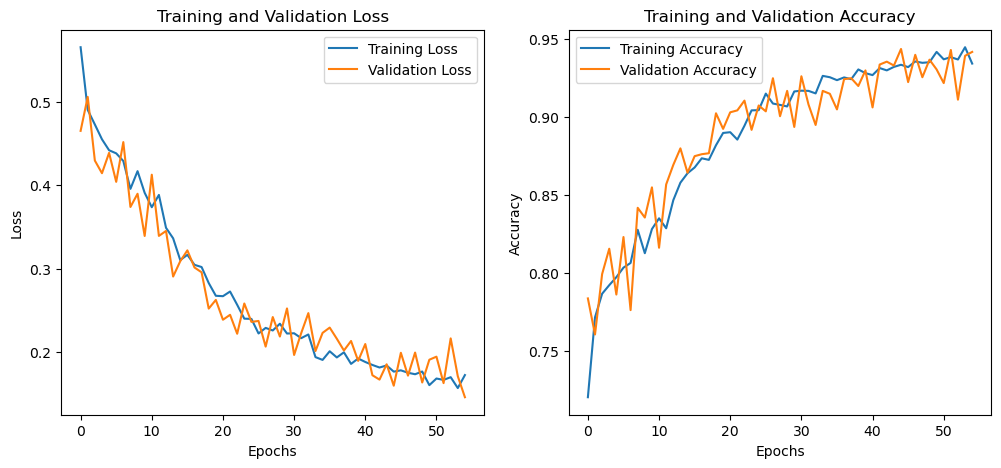

In [17]:
plot_metrics(history.history)

### Results

The result of the training is quite good, it trained for 55 epochs with a low Adam learning rate of 0.0001 because it was getting plateaued with a higher score while training. The model shows an accuracy of **93%** on training and **94%** on validation, on submitting the model to the test data on Kaggle I get a score of **94%**, below is the image of submission.

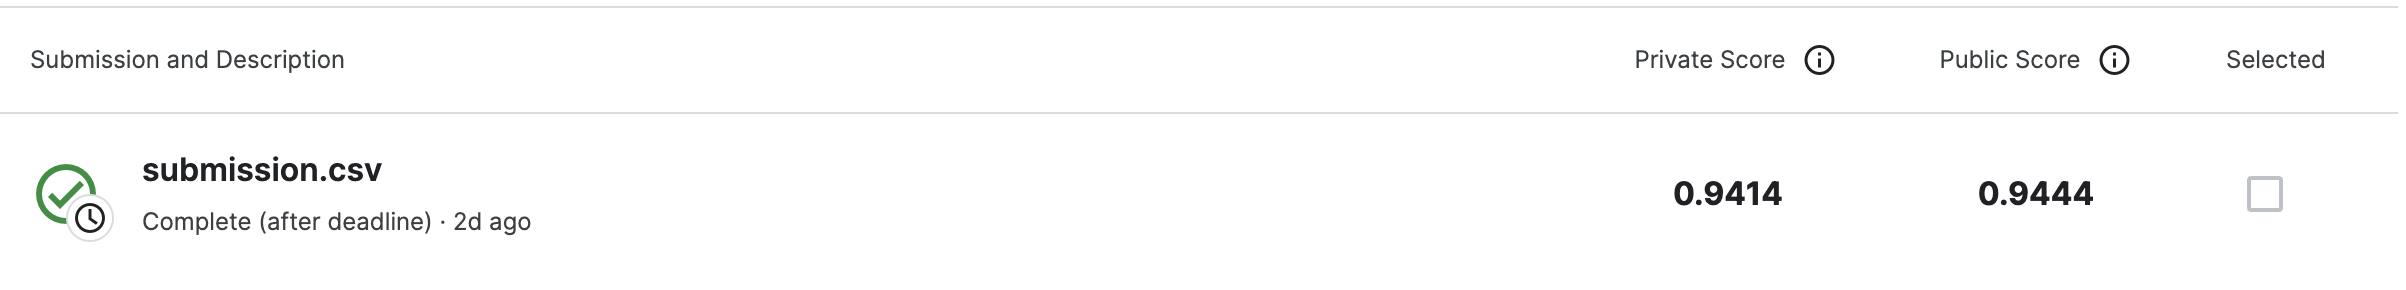

### Saving the model

In [19]:
vgg_model.save("vgg_model.keras")

### Visualising what VGG-16 saw

I am using a random image from the test dataset as input.

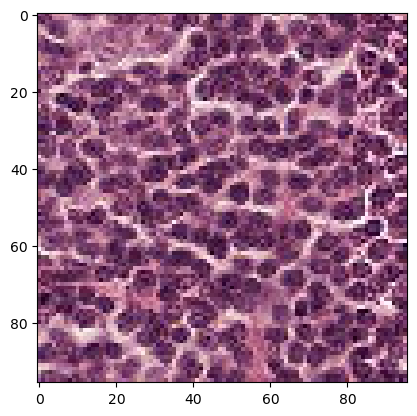

In [88]:
test_image = image.load_img('test/0a0e1de0d1bd38eff2942efc13e5e0420597f295.tif', target_size=(96, 96))

plt.imshow(test_image)
plt.show()

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

### This is the activation of the 5th Covolutional Layer

1/1 [==============================] - 0s 78ms/step


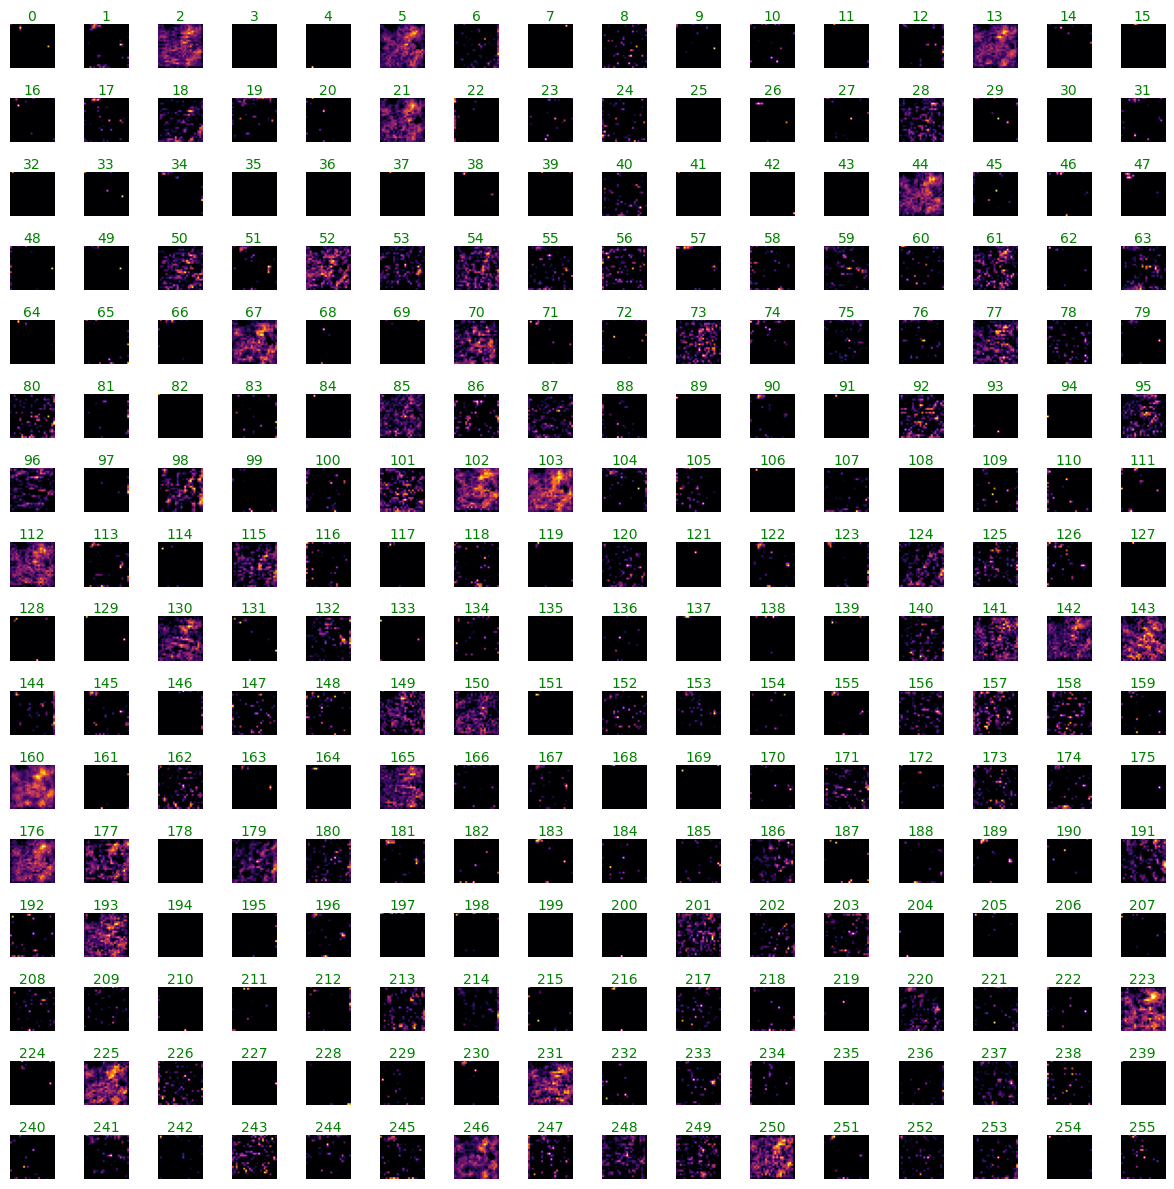

In [129]:
layer_outputs = [layer.output for layer in vgg_model.layers if 'conv' in layer.name]  
activation_model = Model(inputs=vgg_model.input, outputs=layer_outputs)

activations = activation_model.predict(test_image)

layer_number = 5
layer_activation = activations[layer_number]


n_features = layer_activation.shape[-1]
size = int(np.sqrt(n_features))
fig, axes = plt.subplots(size, size, figsize=(12, 12))

for i in range(size * size):
    row = i // size
    col = i % size
    ax = axes[row, col]
    if i < n_features:
        ax.imshow(layer_activation[0, :, :, i], cmap="inferno")
        ax.text(0.5, 1.02, str(i), transform=ax.transAxes, ha="center", va="bottom", color='green')  # Displaying position number on top
    ax.axis('off')

plt.tight_layout()
plt.show()

### Creating an RGB image from three channels of the output

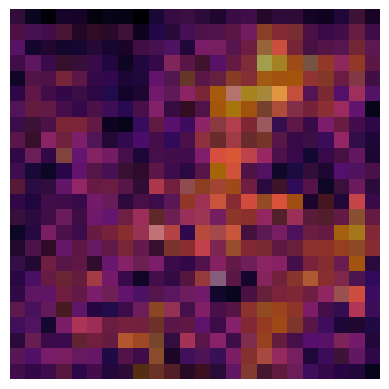

In [137]:
import matplotlib.cm as cm

def process_activation(activations, channel_indices):
    channels = [activations[0, :, :, i] for i in channel_indices]
    
    colormapped_channels = []
    for channel in channels:
        normalized_channel = (channel - channel.min()) / (channel.max() - channel.min())
        colormapped_channels.append(cm.inferno(normalized_channel))
        
    blended_image = np.mean(colormapped_channels, axis=0)[:,:,:3] 
    
    return (blended_image * 255).astype(np.uint8)



rgb_image = process_activation(layer_activation, [101, 102, 103])

plt.imshow(rgb_image)
plt.axis('off')
plt.show()

### Retraining the model with different learning rates and optimizers to see if it gets better

The below example is one of many experiments with learning rate and optimizers, which are mentioned below, this experiment uses the SGD with a 0.0001 lr and 0.9 momentum along with nesterov momentum.

In [136]:
vgg_model.compile(optimizer=SGD(learning_rate = 0.0001, momentum = 0.9, nesterov = True), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, mode='auto')

history = vgg_model.fit(
    train_generator,
    steps_per_epoch= 250,
    validation_data=validation_generator,
    validation_steps = 50,
    epochs=15,
    callbacks = [early_stopping]
)

Epoch 1/15
250/250 [==============================] - 250s 999ms/step - loss: 0.1308 - accuracy: 0.9550 - val_loss: 0.1487 - val_accuracy: 0.9444
Epoch 2/15
250/250 [==============================] - 253s 1s/step - loss: 0.1211 - accuracy: 0.9553 - val_loss: 0.1449 - val_accuracy: 0.9456
Epoch 3/15
250/250 [==============================] - 248s 991ms/step - loss: 0.1172 - accuracy: 0.9571 - val_loss: 0.1623 - val_accuracy: 0.9406
Epoch 4/15
250/250 [==============================] - 248s 992ms/step - loss: 0.1160 - accuracy: 0.9613 - val_loss: 0.1682 - val_accuracy: 0.9413
Epoch 5/15
250/250 [==============================] - 249s 995ms/step - loss: 0.1110 - accuracy: 0.9597 - val_loss: 0.1747 - val_accuracy: 0.9419
Epoch 6/15
250/250 [==============================] - 251s 1s/step - loss: 0.1167 - accuracy: 0.9584 - val_loss: 0.1430 - val_accuracy: 0.9488
Epoch 7/15
250/250 [==============================] - 248s 991ms/step - loss: 0.1175 - accuracy: 0.9590 - val_loss: 0.1581 - val_a

### Results 

| Optimizer | Early Stopped | Improved Performance | Learning Rate |
|-----------|---------------|----------------------|---------------|
|   Adam    | Yes | No | 0.00001|
|SGD| Yes | Not Much | 0.00001|
|SGD| No | Same as before,but better convergence than other tries | 0.001|
|SGD| No | Not Much | 0.0001|



After running several experiments on the model, trying out Adam with a lower learning rate of 0.00001 compared to the 0.0001 which was used to train the model initially, did not show any improvement and was early stopped. Experiments with SGD showed the best results for trainig loss with learning rate 0.00001 but the validation loss increased, SGD with learning rate 0.001 was converging better and was not early stopped but doesn't generalize like the initial model weights with Adam ( 0.0001 ). Using SGD with 0.0001 didn't show much improvement, it improved on the training loss but increased the validation loss than the initial training metric scores. In summary changing the learning rate and using different optimizer didn't show much improvement, other techniques like batch normalization, data agumentation can be used further to improve the results.

# ResNet-152


ResNet was introduced 2015 as a solution to the problem of increasing model error as the model depth got larger. [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385v1.pdf) paper introduced residual connection which forward input of the previous layers to the proceeding layers, using residual learning showed that deep CNNs performed better than shallow CNN like VGG-16/19 and surprisingly these deep CNN like ResNet-152 which is 152 layers deep network was less complex than shallow architectures like VGG, in params size and FLOPS.
Here is an example of ResNet-34 architecture from the paper. 

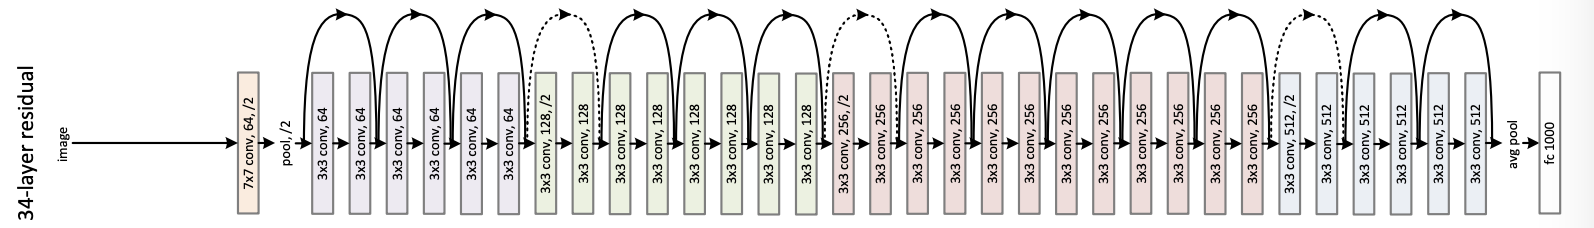

### Implementation Reference

As I am going to implement the ResNet-152 architecture here is the implmentation detail from the paper

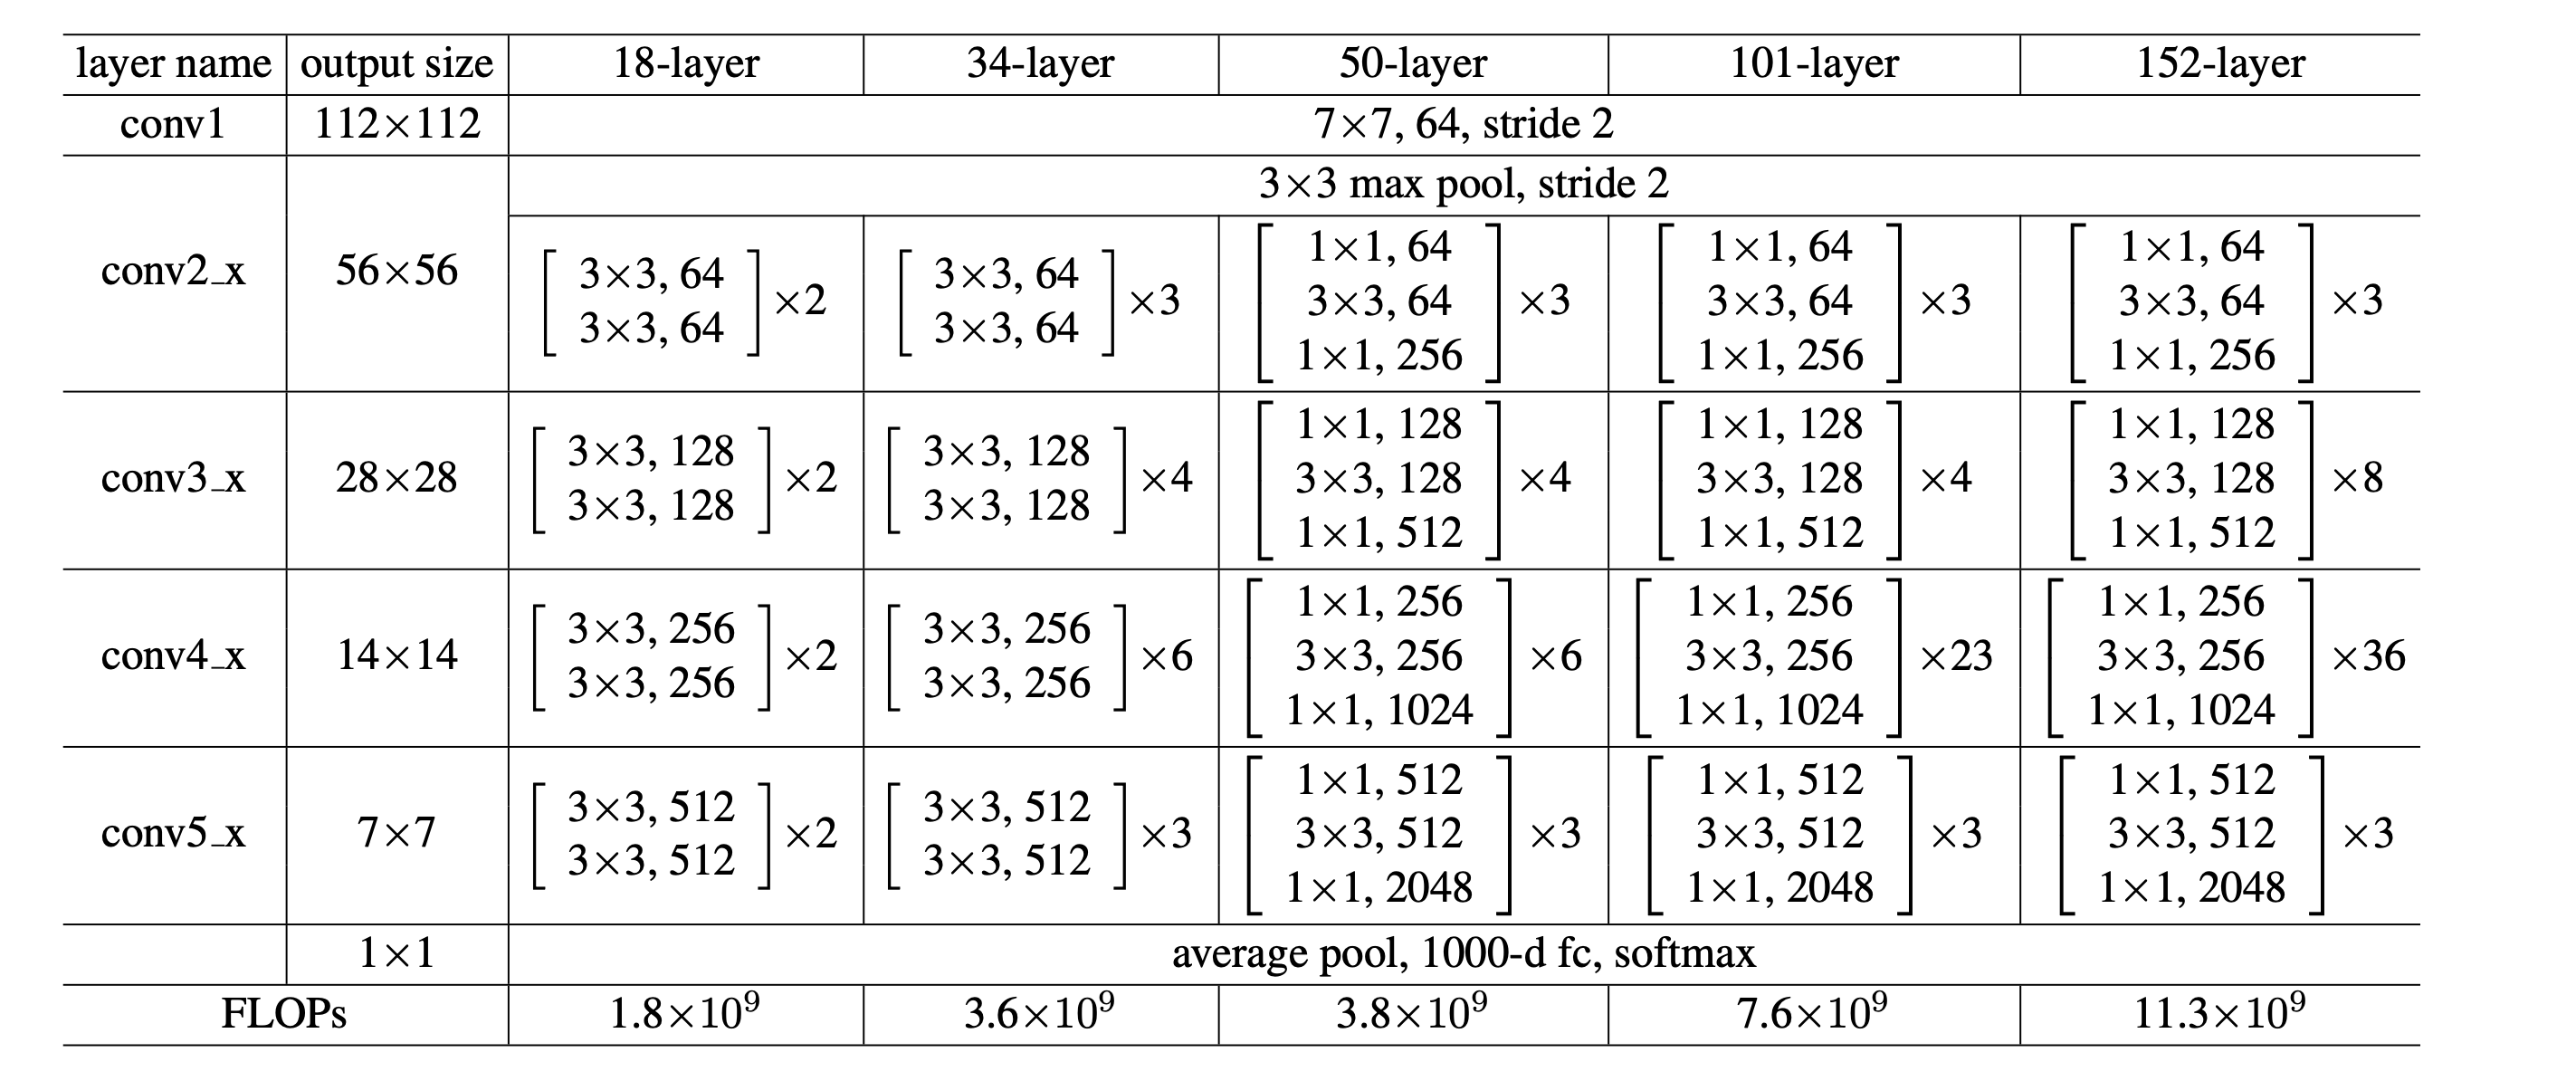

The 152-layer implementation details have been give in the right most coloumn of the table.

### Implementation

In [3]:
def bottleneck_block(input_tensor, filters, transform_shortcut = False, first_block = False):
    if first_block:
        c1 = Conv2D(filters = filters[0], kernel_size = (1,1), strides = (2,2))(input_tensor)
    else:
        c1 = Conv2D(filters = filters[0], kernel_size = (1,1))(input_tensor)
        
    bc1 = BatchNormalization()(c1)
    rb1 = Activation('relu')(bc1)
    
    c2 = Conv2D(filters = filters[1], kernel_size = (3, 3), padding = "same")(rb1)
    bc2 = BatchNormalization()(c2)
    rb2 = Activation('relu')(bc2)
    
    c3 = Conv2D(filters = filters[2], kernel_size = (1, 1))(rb2)
    bc3 = BatchNormalization()(c3)
    rb3 = Activation('relu')(bc3)
    
    if transform_shortcut:
        if first_block:
            strides = (2,2)
        else:
            strides = (1,1)
        shortcut = Conv2D(filters = filters[2], kernel_size = (1,1), strides = strides)(input_tensor)

        sb = BatchNormalization()(shortcut)
        output = add([rb3, sb])
    else:
        output = add([rb3, input_tensor])
    
    return Activation('relu')(output)

def create_section(repeat, filters, input_tensor, first_block_flags = [True, True]):
    previous_output = bottleneck_block(input_tensor, filters, first_block_flags[0], first_block_flags[1])
    
    for i in range(repeat - 2):
        previous_output = bottleneck_block(previous_output, filters)
    
    output = bottleneck_block(previous_output, filters)
    
    return output
    

def ResNet152():
    input_layer = Input(shape = (96, 96, 3))
    
    first_conv = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2))(input_layer)
    
    max_pool = MaxPool2D(pool_size = (3,3), strides = (2,2))(first_conv)
    
    #start of the bottleneck_blocks
    conv2_3 = create_section(3, [64, 64, 256], max_pool, [True, False])
    
    #second section
    conv3_8 = create_section(8, [128, 128, 512], conv2_3)
    
    #third section 
    conv4_36 = create_section(36, [256, 256, 1024], conv3_8)
    
    #fourth section
    conv5_3 = create_section(3, [512, 512, 2048], conv4_36)
    
    #CNN Layers
    
    gap = GlobalAveragePooling2D()(conv5_3)
    dense1 = Dense(1000, activation='relu')(gap)
    output = Dense(1, activation='sigmoid')(dense1)
    
    model = Model(inputs=input_layer, outputs=output)
    
    return model
    

### Creating the model

In [37]:
resnet_model = ResNet152()

In [38]:
resnet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_775 (Conv2D)         (None, 45, 45, 64)           9472      ['input_6[0][0]']             
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)           0         ['conv2d_775[0][0]']          
 g2D)                                                                                             
                                                                                                  
 conv2d_776 (Conv2D)         (None, 22, 22, 64)           4160      ['max_pooling2d_5[0][0]'

### Training

I will use the ImageDataGenerator created above for reading the images, for optiizers I will use Adam with its default setting, and use the ReduceLROnPlateau for decreasing the learning rate when validation loss plateaus, this is similar to how the original ResNet-152 was trained.


In [39]:
resnet_model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks_list = [early_stopping, reduce_lr]

history = resnet_model.fit(train_generator,
    steps_per_epoch= 250,
    validation_data=validation_generator,
    validation_steps = 50,
    epochs=100,
    callbacks = callbacks_list)

Epoch 1/100
250/250 [==============================] - 269s 1s/step - loss: 0.7453 - accuracy: 0.7229 - val_loss: 754.0112 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 265s 1s/step - loss: 0.5997 - accuracy: 0.7617 - val_loss: 13.3033 - val_accuracy: 0.6206 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 264s 1s/step - loss: 0.4690 - accuracy: 0.8037 - val_loss: 1.4170 - val_accuracy: 0.6019 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 264s 1s/step - loss: 0.4380 - accuracy: 0.8120 - val_loss: 0.7625 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - 260s 1s/step - loss: 0.4096 - accuracy: 0.8253 - val_loss: 1.0441 - val_accuracy: 0.6194 - lr: 0.0010
Epoch 6/100
250/250 [==============================] - 260s 1s/step - loss: 0.4155 - accuracy: 0.8204 - val_loss: 1.0693 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 7/100
250/250 [==============================] - 

### Visualising the training

The loss and accuracy have converged well for training with **0.90** validation accuracy and **0.24** loss.

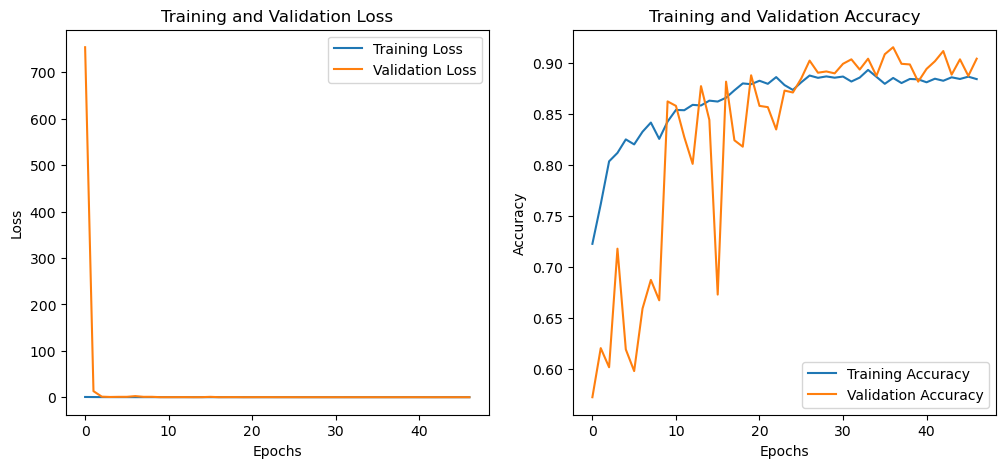

In [40]:
plot_metrics(history.history)

### Saving the model

In [41]:
resnet_model.save("resnet_model_adam.keras")

### Training ResNet-152 with SGD

I will be using the same configuration as the training above for the ResNet model, but with SGD optimizer, to see if it converges faster.

In [6]:
resnet_sgd_model = ResNet152()

In [12]:
resnet_sgd_model.compile(optimizer = "sgd", loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks_list = [early_stopping, reduce_lr]

history = resnet_sgd_model.fit(train_generator,
    steps_per_epoch= 250,
    validation_data=validation_generator,
    validation_steps = 50,
    epochs=100,
    callbacks = callbacks_list)

Epoch 1/100
250/250 [==============================] - 301s 1s/step - loss: 0.7173 - accuracy: 0.6985 - val_loss: 0.8118 - val_accuracy: 0.5044 - lr: 0.0100
Epoch 2/100
250/250 [==============================] - 281s 1s/step - loss: 0.5189 - accuracy: 0.7585 - val_loss: 0.5251 - val_accuracy: 0.7656 - lr: 0.0100
Epoch 3/100
250/250 [==============================] - 284s 1s/step - loss: 0.4800 - accuracy: 0.7776 - val_loss: 0.5632 - val_accuracy: 0.7650 - lr: 0.0100
Epoch 4/100
250/250 [==============================] - 283s 1s/step - loss: 0.4704 - accuracy: 0.7836 - val_loss: 0.4820 - val_accuracy: 0.7850 - lr: 0.0100
Epoch 5/100
250/250 [==============================] - 278s 1s/step - loss: 0.4480 - accuracy: 0.7980 - val_loss: 0.4349 - val_accuracy: 0.8094 - lr: 0.0100
Epoch 6/100
250/250 [==============================] - 278s 1s/step - loss: 0.4343 - accuracy: 0.8037 - val_loss: 0.4071 - val_accuracy: 0.8156 - lr: 0.0100
Epoch 7/100
250/250 [==============================] - 277

### Visualising the training

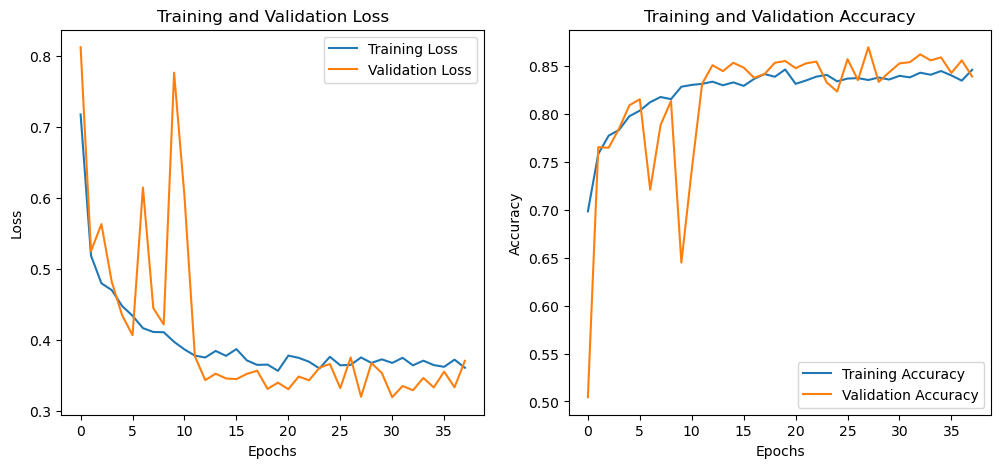

In [15]:
plot_metrics(history.history)

### Results

As per the results above the Adam model is perfroming better than the SGD one with an val_accuracy of 0.90 compared to val_accuracy of SGD which is 0.86, both the adam resnet model as well as the sgd resnet model are not as good as VGG-16 atleast in the training and validation metrics. I will first submit the predictions of both the individually with the results below. 

### Test score for ResNet-152 with Adam
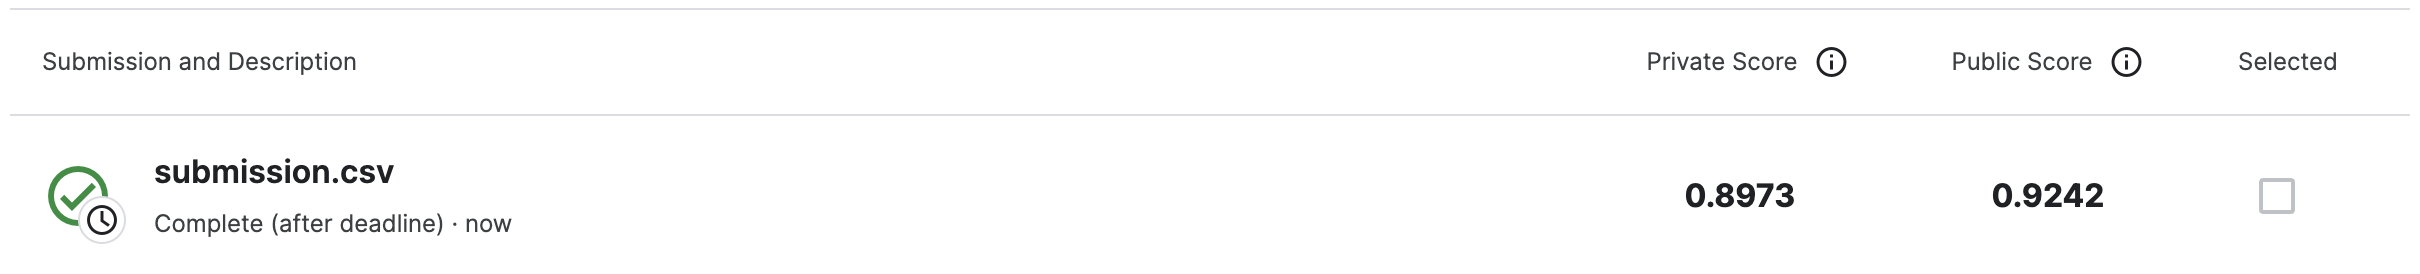

The private score is similar to the score for val_accuracy.

### Test score for ResNet-152 with SGD
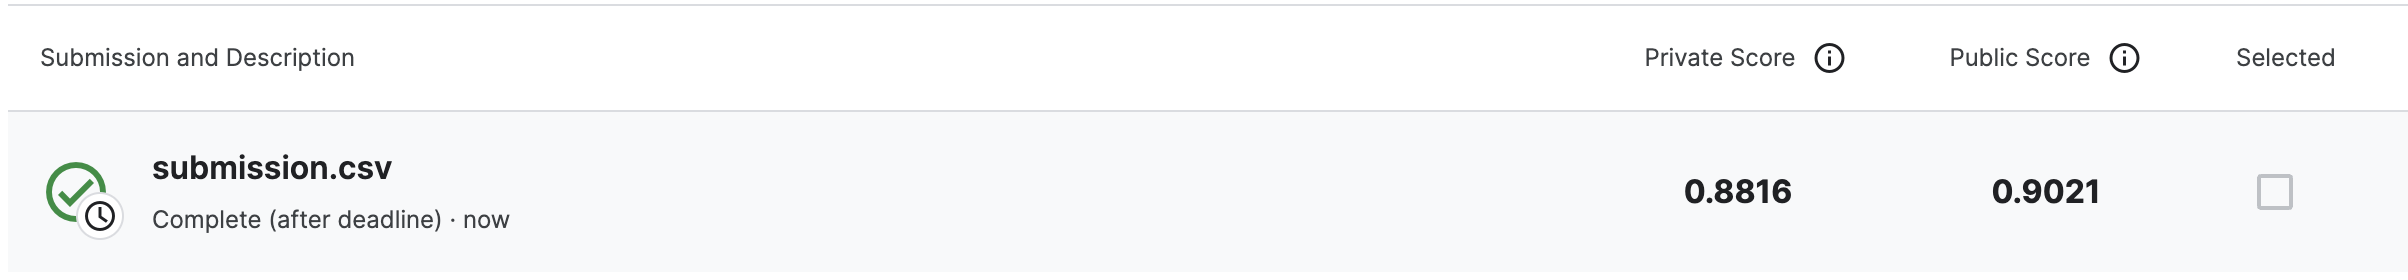
The private score is similar to the score of SGD for val_accuracy.

# Submission code
I have used the following code to submit the test scoring.

In [ ]:
model = resnet_sgd_model


df = pd.read_csv('sample_submission.csv')

def preprocess_image_keras(image_path):
    img = image.load_img(image_path)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

for idx, row in df.iterrows():
    image_path = os.path.join('test', row['id'] + '.tif')
    
    img_array = preprocess_image_keras(image_path)
    
    preds = model.predict(img_array)[0][0]
    
    df.at[idx, 'label'] = preds

df.to_csv('submission.csv', index=False)
print("Prediction Completed")

# Conclusion

I have tried out three models in this notebook, the best performance was given by VGG-16, the ResNet-152 model is not performing as good as VGG with a 4% accuracy difference on this dataset, below is the table with specific metrics of each model

| Model | Accuracy | Loss | Test Score |
|-------|----------|------|------------|
| VGG-16 | 0.94 | 0.14 | 0.94 |
| ResNet-152 | 0.90 | 0.24 | 0.92 |
| ResNet-152 | 0.83 | 0.37 | 0.90 |

Further experiments like using Data Augmentation and Batch Normalization with VGG can increase the performance of the model, experimnets with ResNet using different residual adding techniques can be tried out with different depths like ResNet-18/34/50.